# Zhanibek Meiramkan ADA-2404M

# **Practice 6**

In [30]:
%%writefile task1_opencl_add.cpp
#define CL_TARGET_OPENCL_VERSION 120
#include <CL/cl.h> // opencl
#include <iostream> // вывод
#include <vector> // массивы
#include <fstream> // чтение .cl
#include <cstdlib> // rand
#include <ctime> // time
#include <chrono> // таймер
#include <cmath> // fabs

using namespace std; // чтоб не писать std::

void cl_ok(cl_int err, const char* msg) { // проверка ошибок opencl
    if (err != CL_SUCCESS) { // если ошибка
        cout << "ошибка opencl (" << msg << "): " << err << "\n"; // вывод
        exit(1); // выход
    }
}

string read_text(const char* path) { // читаем файл в строку
    ifstream f(path); // открываем
    if (!f.is_open()) { // если не открылся
        cout << "не могу открыть файл: " << path << "\n"; // вывод
        exit(1); // выход
    }
    string s((istreambuf_iterator<char>(f)), istreambuf_iterator<char>()); // читаем всё
    return s; // возвращаем
}

bool get_device(cl_device_type type, cl_platform_id& out_plat, cl_device_id& out_dev) { // ищем устройство
    cl_uint pcount = 0; // кол-во платформ
    cl_int err = clGetPlatformIDs(0, nullptr, &pcount); // сколько платформ
    if (err != CL_SUCCESS || pcount == 0) return false; // нет платформ
    vector<cl_platform_id> plats(pcount); // список платформ
    cl_ok(clGetPlatformIDs(pcount, plats.data(), nullptr), "get platforms"); // получаем

    for (cl_uint pi = 0; pi < pcount; pi++) { // перебор платформ
        cl_uint dcount = 0; // кол-во устройств
        err = clGetDeviceIDs(plats[pi], type, 0, nullptr, &dcount); // сколько устройств
        if (err != CL_SUCCESS || dcount == 0) continue; // нет
        vector<cl_device_id> devs(dcount); // список устройств
        cl_ok(clGetDeviceIDs(plats[pi], type, dcount, devs.data(), nullptr), "get devices"); // получаем
        out_plat = plats[pi]; // платформа
        out_dev = devs[0]; // первое устройство
        return true; // нашли
    }
    return false; // не нашли
}

double run_cpu_plain(const vector<float>& A, const vector<float>& B, vector<float>& C) { // обычный cpu (без opencl)
    auto s = chrono::high_resolution_clock::now(); // старт
    int n = (int)A.size(); // n
    for (int i = 0; i < n; i++) C[i] = A[i] + B[i]; // сложение
    auto e = chrono::high_resolution_clock::now(); // конец
    return chrono::duration<double, milli>(e - s).count(); // мс
}

double run_gpu_opencl(const vector<float>& A, const vector<float>& B, vector<float>& C) { // opencl gpu
    cl_platform_id plat = nullptr; // платформа
    cl_device_id dev = nullptr; // устройство
    if (!get_device(CL_DEVICE_TYPE_GPU, plat, dev)) return -1.0; // нет gpu

    cl_int err = 0; // ошибки
    cl_context ctx = clCreateContext(nullptr, 1, &dev, nullptr, nullptr, &err); // контекст
    cl_ok(err, "create context"); // ok

    cl_command_queue q = clCreateCommandQueue(ctx, dev, CL_QUEUE_PROFILING_ENABLE, &err); // очередь
    cl_ok(err, "create queue"); // ok

    string src = read_text("kernel_add.cl"); // читаем ядро
    const char* csrc = src.c_str(); // c-string
    size_t srclen = src.size(); // длина

    cl_program prog = clCreateProgramWithSource(ctx, 1, &csrc, &srclen, &err); // программа
    cl_ok(err, "create program"); // ok

    err = clBuildProgram(prog, 1, &dev, nullptr, nullptr, nullptr); // build
    if (err != CL_SUCCESS) { // если не собралась
        size_t log_size = 0; // лог
        clGetProgramBuildInfo(prog, dev, CL_PROGRAM_BUILD_LOG, 0, nullptr, &log_size); // размер
        vector<char> log(log_size); // буфер
        clGetProgramBuildInfo(prog, dev, CL_PROGRAM_BUILD_LOG, log_size, log.data(), nullptr); // читаем
        cout << "build log:\n" << log.data() << "\n"; // вывод
        cl_ok(err, "build program"); // ошибка
    }

    cl_kernel ker = clCreateKernel(prog, "vector_add", &err); // kernel
    cl_ok(err, "create kernel"); // ok

    int n = (int)A.size(); // n
    size_t bytes = (size_t)n * sizeof(float); // bytes

    cl_mem dA = clCreateBuffer(ctx, CL_MEM_READ_ONLY, bytes, nullptr, &err); // A
    cl_ok(err, "buffer A"); // ok
    cl_mem dB = clCreateBuffer(ctx, CL_MEM_READ_ONLY, bytes, nullptr, &err); // B
    cl_ok(err, "buffer B"); // ok
    cl_mem dC = clCreateBuffer(ctx, CL_MEM_WRITE_ONLY, bytes, nullptr, &err); // C
    cl_ok(err, "buffer C"); // ok

    cl_ok(clEnqueueWriteBuffer(q, dA, CL_TRUE, 0, bytes, A.data(), 0, nullptr, nullptr), "write A"); // H2D
    cl_ok(clEnqueueWriteBuffer(q, dB, CL_TRUE, 0, bytes, B.data(), 0, nullptr, nullptr), "write B"); // H2D

    cl_ok(clSetKernelArg(ker, 0, sizeof(cl_mem), &dA), "arg0"); // A
    cl_ok(clSetKernelArg(ker, 1, sizeof(cl_mem), &dB), "arg1"); // B
    cl_ok(clSetKernelArg(ker, 2, sizeof(cl_mem), &dC), "arg2"); // C
    cl_ok(clSetKernelArg(ker, 3, sizeof(int), &n), "arg3"); // n

    size_t global = (size_t)n; // global
    size_t local = 256; // local
    if (global % local != 0) global = ((global / local) + 1) * local; // округляем

    cl_event ev = nullptr; // event
    cl_ok(clEnqueueNDRangeKernel(q, ker, 1, nullptr, &global, &local, 0, nullptr, &ev), "run kernel"); // запуск
    cl_ok(clFinish(q), "finish"); // ждём

    cl_ok(clEnqueueReadBuffer(q, dC, CL_TRUE, 0, bytes, C.data(), 0, nullptr, nullptr), "read C"); // D2H

    cl_ulong t0 = 0; // start
    cl_ulong t1 = 0; // end
    cl_ok(clGetEventProfilingInfo(ev, CL_PROFILING_COMMAND_START, sizeof(cl_ulong), &t0, nullptr), "profile start"); // start
    cl_ok(clGetEventProfilingInfo(ev, CL_PROFILING_COMMAND_END, sizeof(cl_ulong), &t1, nullptr), "profile end"); // end

    double ms = (double)(t1 - t0) / 1e6; // ns -> ms

    clReleaseEvent(ev); // free
    clReleaseMemObject(dA); // free
    clReleaseMemObject(dB); // free
    clReleaseMemObject(dC); // free
    clReleaseKernel(ker); // free
    clReleaseProgram(prog); // free
    clReleaseCommandQueue(q); // free
    clReleaseContext(ctx); // free

    return ms; // ms
}

bool check_add(const vector<float>& A, const vector<float>& B, const vector<float>& C) { // проверка
    int n = (int)A.size(); // n
    for (int i = 0; i < n; i++) { // цикл
        float ref = A[i] + B[i]; // эталон
        if (fabs(C[i] - ref) > 1e-5f) return false; // если ошибка
    }
    return true; // ок
}

int main() { // main
    srand((unsigned)time(0)); // seed
    int sizes[3] = {10000, 100000, 1000000}; // размеры

    cout << "n,cpu_ms,gpu_ms,ok_cpu,ok_gpu\n"; // csv

    for (int t = 0; t < 3; t++) { // цикл
        int n = sizes[t]; // n
        vector<float> A(n); // A
        vector<float> B(n); // B
        vector<float> Ccpu(n); // C cpu
        vector<float> Cgpu(n); // C gpu

        for (int i = 0; i < n; i++) { // fill
            A[i] = (float)(rand() % 1000) / 10.0f; // A
            B[i] = (float)(rand() % 1000) / 10.0f; // B
        }

        double cpu_ms = run_cpu_plain(A, B, Ccpu); // cpu plain
        double gpu_ms = run_gpu_opencl(A, B, Cgpu); // gpu opencl

        int ok_cpu = check_add(A, B, Ccpu) ? 1 : 0; // ok cpu
        int ok_gpu = (gpu_ms < 0) ? 0 : (check_add(A, B, Cgpu) ? 1 : 0); // ok gpu

        cout << n << "," << cpu_ms << "," << gpu_ms << "," << ok_cpu << "," << ok_gpu << "\n"; // csv строка
    }

    return 0; // конец
}


Overwriting task1_opencl_add.cpp


In [31]:
%%writefile kernel_add.cl
__kernel void vector_add(__global const float* A, __global const float* B, __global float* C, int n) {
    int id = get_global_id(0); // id
    if (id < n) C[id] = A[id] + B[id]; // сложение
}


Overwriting kernel_add.cl


In [32]:
%%writefile task2_opencl_matmul.cpp
#include <CL/cl.h> // opencl
#include <iostream> // вывод
#include <vector> // массивы
#include <fstream> // чтение .cl
#include <cstdlib> // rand
#include <ctime> // time
#include <chrono> // таймер
#include <cmath> // fabs

using namespace std; // чтоб не писать std::

void cl_ok(cl_int err, const char* msg) { // проверка ошибок opencl
    if (err != CL_SUCCESS) { // если ошибка
        cout << "ошибка opencl (" << msg << "): " << err << "\n"; // вывод
        exit(1); // выход
    }
}

string read_text(const char* path) { // читаем файл в строку
    ifstream f(path); // открываем
    if (!f.is_open()) { // если не открылся
        cout << "не могу открыть файл: " << path << "\n"; // вывод
        exit(1); // выход
    }
    string s((istreambuf_iterator<char>(f)), istreambuf_iterator<char>()); // читаем
    return s; // строка
}

bool get_device(cl_device_type type, cl_platform_id& out_plat, cl_device_id& out_dev) { // ищем устройство
    cl_uint pcount = 0; // платформы
    cl_int err = clGetPlatformIDs(0, nullptr, &pcount); // сколько
    if (err != CL_SUCCESS || pcount == 0) return false; // нет
    vector<cl_platform_id> plats(pcount); // список
    cl_ok(clGetPlatformIDs(pcount, plats.data(), nullptr), "get platforms"); // получаем
    for (cl_uint pi = 0; pi < pcount; pi++) { // перебор
        cl_uint dcount = 0; // девайсы
        err = clGetDeviceIDs(plats[pi], type, 0, nullptr, &dcount); // сколько
        if (err != CL_SUCCESS || dcount == 0) continue; // нет
        vector<cl_device_id> devs(dcount); // список
        cl_ok(clGetDeviceIDs(plats[pi], type, dcount, devs.data(), nullptr), "get devices"); // получаем
        out_plat = plats[pi]; // платформа
        out_dev = devs[0]; // девайс
        return true; // ок
    }
    return false; // нет
}

void cpu_matmul(const vector<float>& A, const vector<float>& B, vector<float>& C, int N, int M, int K) { // cpu умножение
    for (int i = 0; i < N; i++) { // строки
        for (int j = 0; j < K; j++) { // столбцы
            float sum = 0.0f; // сумма
            for (int t = 0; t < M; t++) { // по M
                sum += A[i * M + t] * B[t * K + j]; // формула
            }
            C[i * K + j] = sum; // записали
        }
    }
}

double run_matmul_gpu(const vector<float>& A, const vector<float>& B, vector<float>& C, int N, int M, int K) { // opencl matmul
    cl_platform_id plat = nullptr; // платформа
    cl_device_id dev = nullptr; // девайс
    if (!get_device(CL_DEVICE_TYPE_GPU, plat, dev)) return -1.0; // если нет gpu

    cl_int err = 0; // ошибки
    cl_context ctx = clCreateContext(nullptr, 1, &dev, nullptr, nullptr, &err); // контекст
    cl_ok(err, "create context"); // проверка
    cl_command_queue q = clCreateCommandQueue(ctx, dev, CL_QUEUE_PROFILING_ENABLE, &err); // очередь
    cl_ok(err, "create queue"); // проверка

    string src = read_text("kernel_matmul.cl"); // ядро
    const char* csrc = src.c_str(); // c-string
    size_t srclen = src.size(); // длина

    cl_program prog = clCreateProgramWithSource(ctx, 1, &csrc, &srclen, &err); // программа
    cl_ok(err, "create program"); // проверка

    err = clBuildProgram(prog, 1, &dev, nullptr, nullptr, nullptr); // build
    if (err != CL_SUCCESS) { // если не собралась
        size_t log_size = 0; // лог
        clGetProgramBuildInfo(prog, dev, CL_PROGRAM_BUILD_LOG, 0, nullptr, &log_size); // размер
        vector<char> log(log_size); // буфер
        clGetProgramBuildInfo(prog, dev, CL_PROGRAM_BUILD_LOG, log_size, log.data(), nullptr); // читаем
        cout << "build log:\n" << log.data() << "\n"; // вывод
        cl_ok(err, "build program"); // ошибка
    }

    cl_kernel ker = clCreateKernel(prog, "matmul", &err); // kernel
    cl_ok(err, "create kernel"); // проверка

    size_t bytesA = (size_t)N * M * sizeof(float); // байты A
    size_t bytesB = (size_t)M * K * sizeof(float); // байты B
    size_t bytesC = (size_t)N * K * sizeof(float); // байты C

    cl_mem dA = clCreateBuffer(ctx, CL_MEM_READ_ONLY, bytesA, nullptr, &err); // A
    cl_ok(err, "buffer A"); // ok
    cl_mem dB = clCreateBuffer(ctx, CL_MEM_READ_ONLY, bytesB, nullptr, &err); // B
    cl_ok(err, "buffer B"); // ok
    cl_mem dC = clCreateBuffer(ctx, CL_MEM_WRITE_ONLY, bytesC, nullptr, &err); // C
    cl_ok(err, "buffer C"); // ok

    cl_ok(clEnqueueWriteBuffer(q, dA, CL_TRUE, 0, bytesA, A.data(), 0, nullptr, nullptr), "write A"); // H2D A
    cl_ok(clEnqueueWriteBuffer(q, dB, CL_TRUE, 0, bytesB, B.data(), 0, nullptr, nullptr), "write B"); // H2D B

    cl_ok(clSetKernelArg(ker, 0, sizeof(cl_mem), &dA), "arg0"); // A
    cl_ok(clSetKernelArg(ker, 1, sizeof(cl_mem), &dB), "arg1"); // B
    cl_ok(clSetKernelArg(ker, 2, sizeof(cl_mem), &dC), "arg2"); // C
    cl_ok(clSetKernelArg(ker, 3, sizeof(int), &N), "arg3"); // N
    cl_ok(clSetKernelArg(ker, 4, sizeof(int), &M), "arg4"); // M
    cl_ok(clSetKernelArg(ker, 5, sizeof(int), &K), "arg5"); // K

    size_t global[2] = {(size_t)N, (size_t)K}; // N x K
    size_t local[2] = {16, 16}; // блок 16x16

    if (global[0] % local[0] != 0) global[0] = ((global[0] / local[0]) + 1) * local[0]; // округл
    if (global[1] % local[1] != 0) global[1] = ((global[1] / local[1]) + 1) * local[1]; // округл

    cl_event ev = nullptr; // событие
    cl_ok(clEnqueueNDRangeKernel(q, ker, 2, nullptr, global, local, 0, nullptr, &ev), "run kernel"); // запуск
    cl_ok(clFinish(q), "finish"); // ждём

    cl_ok(clEnqueueReadBuffer(q, dC, CL_TRUE, 0, bytesC, C.data(), 0, nullptr, nullptr), "read C"); // D2H

    cl_ulong t0 = 0; // start
    cl_ulong t1 = 0; // end
    cl_ok(clGetEventProfilingInfo(ev, CL_PROFILING_COMMAND_START, sizeof(cl_ulong), &t0, nullptr), "profile start"); // start
    cl_ok(clGetEventProfilingInfo(ev, CL_PROFILING_COMMAND_END, sizeof(cl_ulong), &t1, nullptr), "profile end"); // end

    double ms = (double)(t1 - t0) / 1e6; // мс

    clReleaseEvent(ev); // событие
    clReleaseMemObject(dA); // free
    clReleaseMemObject(dB); // free
    clReleaseMemObject(dC); // free
    clReleaseKernel(ker); // free
    clReleaseProgram(prog); // free
    clReleaseCommandQueue(q); // free
    clReleaseContext(ctx); // free

    return ms; // время
}

bool check_matmul(const vector<float>& X, const vector<float>& Y) { // сравнение матриц
    int n = (int)X.size(); // размер
    for (int i = 0; i < n; i++) { // цикл
        if (fabs(X[i] - Y[i]) > 1e-3f) return false; // погрешность
    }
    return true; // ок
}

int main() { // main
    srand((unsigned)time(0)); // seed

    int N = 256; // N
    int M = 256; // M
    int K = 256; // K

    vector<float> A(N * M); // A
    vector<float> B(M * K); // B
    vector<float> Ccpu(N * K); // C cpu
    vector<float> Cgpu(N * K); // C gpu

    for (int i = 0; i < N * M; i++) A[i] = (float)(rand() % 100) / 10.0f; // fill A
    for (int i = 0; i < M * K; i++) B[i] = (float)(rand() % 100) / 10.0f; // fill B

    auto s1 = chrono::high_resolution_clock::now(); // старт cpu
    cpu_matmul(A, B, Ccpu, N, M, K); // cpu
    auto e1 = chrono::high_resolution_clock::now(); // конец cpu
    double cpu_ms = chrono::duration<double, milli>(e1 - s1).count(); // мс cpu

    double gpu_ms = run_matmul_gpu(A, B, Cgpu, N, M, K); // opencl gpu

    int ok = (gpu_ms < 0) ? 0 : (check_matmul(Ccpu, Cgpu) ? 1 : 0); // проверка

    cout << "n,m,k,cpu_ms,gpu_ms,ok\n"; // csv
    cout << N << "," << M << "," << K << "," << cpu_ms << "," << gpu_ms << "," << ok << "\n"; // строка

    return 0; // конец
}


Overwriting task2_opencl_matmul.cpp


In [33]:
%%writefile kernel_matmul.cl
__kernel void matmul(__global const float* A, __global const float* B, __global float* C, int N, int M, int K) {
    int row = get_global_id(0); // строка
    int col = get_global_id(1); // столбец
    if (row < N && col < K) { // границы
        float sum = 0.0f; // сумма
        for (int t = 0; t < M; t++) { // по M
            sum += A[row * M + t] * B[t * K + col]; // формула
        }
        C[row * K + col] = sum; // записали
    }
}


Overwriting kernel_matmul.cl


In [34]:
!g++ task1_opencl_add.cpp -o task1 -lOpenCL
!./task1 > results_add.csv
!cat results_add.csv


n,cpu_ms,gpu_ms,ok_cpu,ok_gpu
10000,0.073311,0.013728,1,1
100000,0.773461,0.01472,1,1
1000000,7.80943,0.052512,1,1


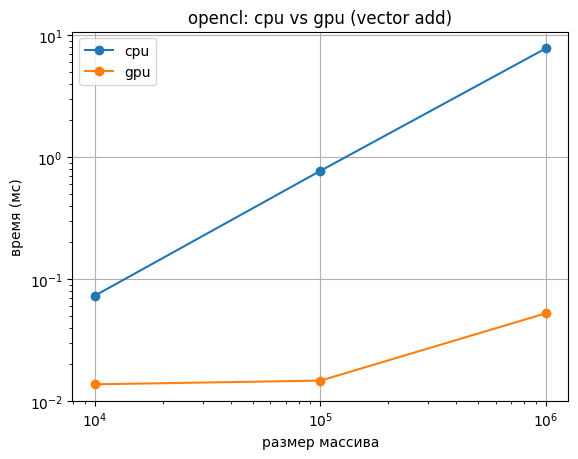

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results_add.csv")

plt.figure()
plt.plot(df["n"], df["cpu_ms"], marker="o")
plt.plot(df["n"], df["gpu_ms"], marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("размер массива")
plt.ylabel("время (мс)")
plt.title("opencl: cpu vs gpu (vector add)")
plt.legend(["cpu", "gpu"])
plt.grid(True)
plt.show()
